In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
from PIL import Image
import os
from os import listdir
from os.path import isfile, join
import glob
import random
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


from tqdm import tqdm_notebook

In [3]:
!pip install --upgrade wandb

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
def set_seed(n):
    torch.backends.cudnn.deterministic=True
    torch.manual_seed = n
    random.seed(n)
    np.random.seed(n)

In [5]:
class mod_dataset(Dataset):

    def __init__(self, file_names, root_dir, norm=True, transform=None):
        self.file_names = file_names
        self.root_dir = root_dir
        self.transform = transform
        if norm:
            self.norm = True
            self.normalizer = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_names[idx])
        image = Image.open(img_name)

        to_tensor = transforms.ToTensor()
        image = to_tensor(image)

        w = image.shape[2]

        B = image[:, :, :w // 2]
        A = image[:, :, w // 2:]
        if self.norm:
            A = self.normalizer(A)
            B = self.normalizer(B)

        if self.transform:
            AB = torch.cat((A, B), 0)
            AB = self.transform(AB)
            A = AB[:3, :]
            B = AB[3:, :]

        sample = [A, B]

        return sample

In [6]:
class C_k(nn.Module):
    def __init__(self, n_inn, n_filters, stride=2):
      super(C_k, self).__init__()
      if n_inn == 3 or n_inn == 6:
        self.conv_br = nn.Sequential(
            nn.Conv2d(n_inn, n_filters, 4, stride=stride, padding=1),
            nn.LeakyReLU(0.2, True)
        )
      else:
        self.conv_br = nn.Sequential(
            nn.Conv2d(n_inn, n_filters, 4, stride=stride, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2, True)
        )
    
    def forward(self, x):
      return self.conv_br(x)

class Encoder(nn.Module):
    def __init__(self, device):
        super(Encoder, self).__init__()
        dims = [[3, 64], [64, 128], [128, 256], [256, 512], [512, 512], [512, 512], [512, 512], [512, 512]]
        self.convs = nn.ModuleList([C_k(i[0], i[1]) for i in dims])
        self.device = device
             
        
    def forward(self, x):
        skips = []
        for layer in self.convs:
          x = layer(x)
          skips.append(x)
        
        return skips

In [7]:
class CD_k(nn.Module):
    def __init__(self, n_inn, n_filters, dropout=False, stride=2):
      super(CD_k, self).__init__()
      if dropout:
        self.conv_bdr = nn.Sequential(
            nn.ConvTranspose2d(n_inn, n_filters, 4, stride=stride, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.Dropout(0.5),
            nn.ReLU(True)
        )
      else:
        self.conv_bdr = nn.Sequential(
            nn.ConvTranspose2d(n_inn, n_filters, 4, stride=stride, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(True)
        )
    
    def forward(self, x):
      return self.conv_bdr(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        dims = [[512, 512, True], [1024, 512, True], [1024, 512, True], [1024, 512, False], [1024, 512, False], [768, 512, False], [640, 256, False], [320, 128, False]]
        self.convs = nn.ModuleList([CD_k(i[0], i[1]) for i in dims])
        self.last = nn.ConvTranspose2d(128, 3, 1, 1)
        self.t = nn.Tanh()

             
        
    def forward(self, skips):
        skips.reverse()
        x = skips[0]
        for i, layer in enumerate(self.convs):
          if i != 0:
            #print(x.shape, skips[i].shape, torch.cat((x, skips[i]), dim=1).shape)
            x = torch.cat((x, skips[i]), dim=1)
          x = layer(x)
        x = self.t(self.last(x))
        return x

In [8]:
class Generator(nn.Module):
    def __init__(self, device):
        super(Generator, self).__init__()

        self.encoder = Encoder(device)

        self.decoder = Decoder()
    

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        dims = [[6, 64, 2], [64, 128, 2], [128, 256, 2], [256, 512, 1]]
        self.convs = nn.ModuleList([C_k(i[0], i[1], stride=i[2]) for i in dims])
        self.last = nn.Conv2d(dims[-1][1], 1, 1, 1)
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        for layer in self.convs:
          x = layer(x)
        x = self.last(x)
        #x = self.sigm(x)
        return x

    def require_grad(self, req_g):
        for p in self.parameters():
          p.requires_grad = req_g

        
        

In [10]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [11]:
class Pix2Pix(nn.Module):
    def __init__(self, device, lmbda=100, lr=2e-4, betas=(0.5, 0.999)):
        super(Pix2Pix, self).__init__()

        self.generator = Generator(device)
        self.discriminator = Discriminator()
        self.g_optimizer = Adam(self.generator.parameters(), lr= lr, betas=betas)
        self.d_optimizer = Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        print('Generator parameters:', count_parameters(self.generator))
        print('Discriminator parameters:', count_parameters(self.discriminator))
        self.criterion_gan = nn.BCEWithLogitsLoss()
        self.criterion_l1 = nn.L1Loss()
        self.lmbda=lmbda
        self.device=device

        

        
    def forward(self, A):
        gen_B = self.generator(A)
        return gen_B
    
    def D_backward(self, A_B, A_gen_B):
        pred = self.discriminator(A_gen_B.detach())
        gen_loss = self.criterion_gan(pred, torch.zeros(pred.shape).to(self.device))

        pred = self.discriminator(A_B)
        truth_loss = self.criterion_gan(pred, torch.ones(pred.shape).to(self.device))

        final_D_loss = (gen_loss + truth_loss) / 2.0
        batch_loss = final_D_loss.item()
        final_D_loss.backward()
        return batch_loss
    
    
    def G_backward(self, B, gen_B, A_gen_B):
        pred = self.discriminator(A_gen_B)
        bce_loss = self.criterion_gan(pred, torch.ones(pred.shape).to(self.device))

        l1_loss = self.criterion_l1(gen_B, B)*self.lmbda
        final_G_loss = bce_loss + l1_loss
        batch_loss = final_G_loss.item()
        final_G_loss.backward()

        return batch_loss



    def step(self, A, B):
      gen_B = self.generator(A)

      A_gen_B = torch.cat((A, gen_B), 1)
      A_B = torch.cat((A, B), 1)

      self.discriminator.require_grad(True)
      self.d_optimizer.zero_grad()
      dloss = self.D_backward(A_B, A_gen_B)
      self.d_optimizer.step()

      self.discriminator.require_grad(False)


      self.g_optimizer.zero_grad()
      gloss = self.G_backward(B, gen_B, A_gen_B)
      self.g_optimizer.step()
      return gloss, dloss


        
        

In [12]:
def show_tensor(img, text=None):
  to_pil = transforms.ToPILImage()
  img = to_pil(img)
  if text:
    print(text)
  imshow(img)
  plt.show()

def show_tensors(imgs, texts=None):
  to_pil = transforms.ToPILImage()
  fig = plt.figure(figsize=(15, 15))
  for i in range(len(imgs)):
    a = fig.add_subplot(1, 3, i+1)
    img = to_pil(imgs[i])
    imgplot = plt.imshow(img)
    if texts:
      a.set_title(texts[i])
  plt.show()


def prediction(model, A, B, device):
  denorm = transforms.Normalize(mean=(-1.0, -1.0, -1.0), std=(2.0, 2.0, 2.0))
  A = A.to(device) 
  with torch.no_grad():
    pred = model.generator(A)
  A = A.cpu()
  pred = pred.cpu()
  B = B
  print(A.shape,pred.shape, B.shape)
  for i in range(len(A)):
    dn_A = denorm(A[i])
    dn_pred = denorm(pred[i])
    dn_B = denorm(B[i])
    show_tensors([dn_A, dn_pred, dn_B], ['input', 'prediction', 'target'])

In [15]:
set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model = Pix2Pix(device, lmbda=90, lr=3e-4).to(device)

Generator parameters: 66869443
Discriminator parameters: 2761921


In [17]:
batch_size = 32

train_path = '../input/facades/facades/train'
data_train = [f for f in listdir(train_path) if isfile(join(train_path, f))]

train_dataset = mod_dataset(data_train, train_path, transform=transforms.Compose([transforms.Resize((286, 286)), transforms.RandomCrop((256, 256)), transforms.RandomHorizontalFlip()]))


val_path = '../input/facades/facades/val'
data_val = [f for f in listdir(val_path) if isfile(join(val_path, f))]

val_dataset = mod_dataset(data_val, val_path, transform=transforms.Compose([transforms.Resize((286, 286)), transforms.RandomCrop((256, 256))]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=True)

In [18]:
test_path = '../input/facades/facades/test'
data_test = [f for f in listdir(test_path) if isfile(join(test_path, f))]

test_dataset = mod_dataset(data_test, test_path, transform=transforms.Compose([transforms.Resize((286, 286)), transforms.RandomCrop((256, 256))]))
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True)

epochs = 800

pbar = tqdm_notebook(total = epochs*(len(train_dataset)//batch_size))
for epoch in range(epochs):
    running_loss_d = 0.0
    running_loss_g = 0.0
    val_loss = 0.0

    ctr=0
    val_ctr=0

    model.train()
    for batch in train_loader:
        A, B = batch
        A = A.to(device)
        B = B.to(device)
        gloss, dloss = model.step(A, B)
        running_loss_g += gloss
        running_loss_d += dloss
        ctr+=1
        pbar.update(1)
    wandb.log({"Generator loss:": running_loss_g/ctr, "Discriminator loss:": running_loss_d/ctr})
    #print('epoch', epoch+1, ':', 'Generator loss:', running_loss_g/ctr, 'Discriminator loss:', running_loss_d/ctr)
    if (epoch+1) % 40 == 0:
        print('epoch:', epoch+1)
        for batch in val_loader:
            test_A, test_B = batch
            prediction(model, test_A, test_B, device)
            break


pbar.close()

In [ ]:
epochs = 800

pbar = tqdm_notebook(total = epochs*(len(train_dataset)//batch_size))
for epoch in range(epochs):
    running_loss_d = 0.0
    running_loss_g = 0.0
    val_loss = 0.0

    ctr=0
    val_ctr=0

    model.train()
    for batch in train_loader:
        A, B = batch
        A = A.to(device)
        B = B.to(device)
        gloss, dloss = model.step(A, B)
        running_loss_g += gloss
        running_loss_d += dloss
        ctr+=1
        pbar.update(1)
    wandb.log({"Generator loss:": running_loss_g/ctr, "Discriminator loss:": running_loss_d/ctr})
    #print('epoch', epoch+1, ':', 'Generator loss:', running_loss_g/ctr, 'Discriminator loss:', running_loss_d/ctr)
    if (epoch+1) % 40 == 0:
        print('epoch:', epoch+1)
        for batch in val_loader:
            test_A, test_B = batch
            prediction(model, test_A, test_B, device)
            break


pbar.close()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 840
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])


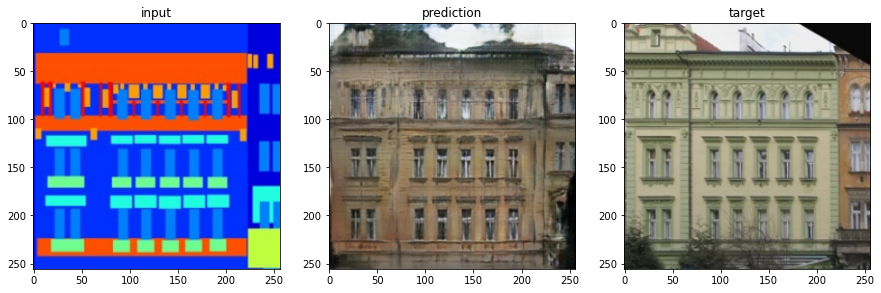

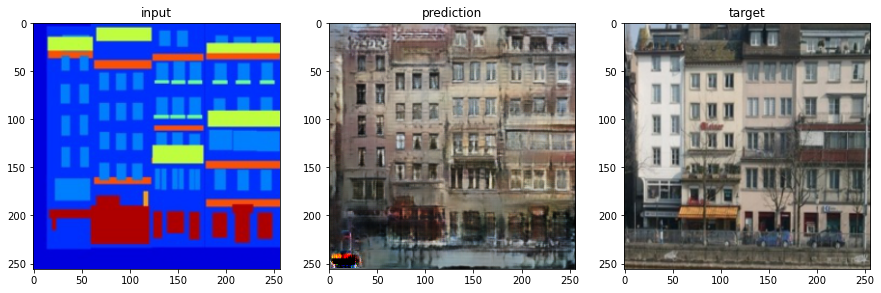

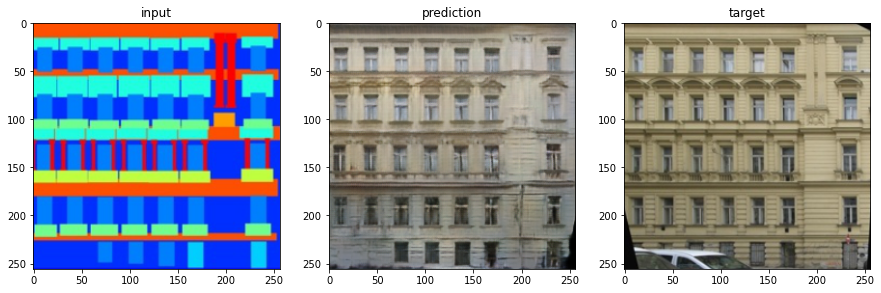

epoch: 880
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])


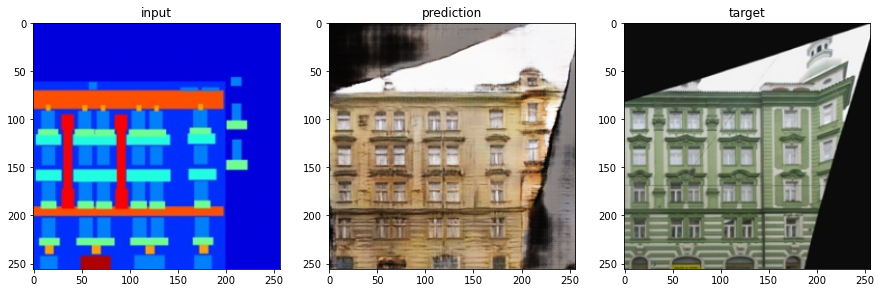

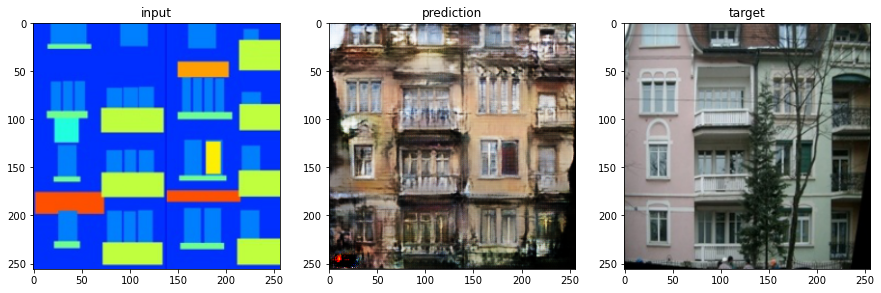

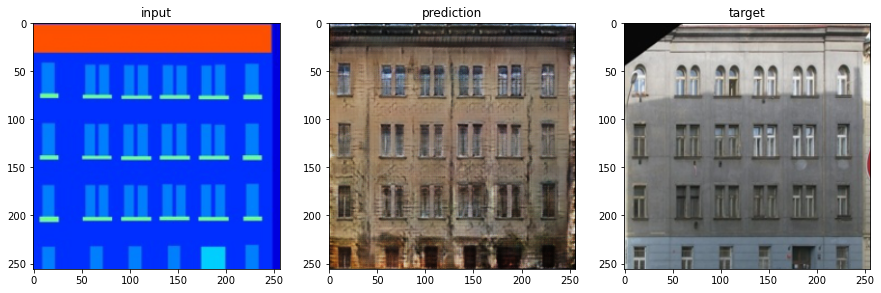

epoch: 920
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])


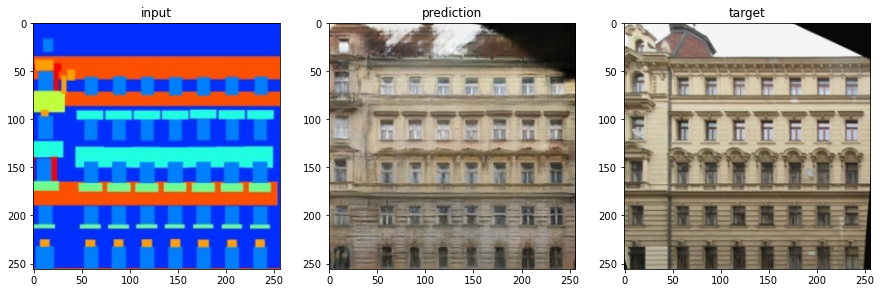

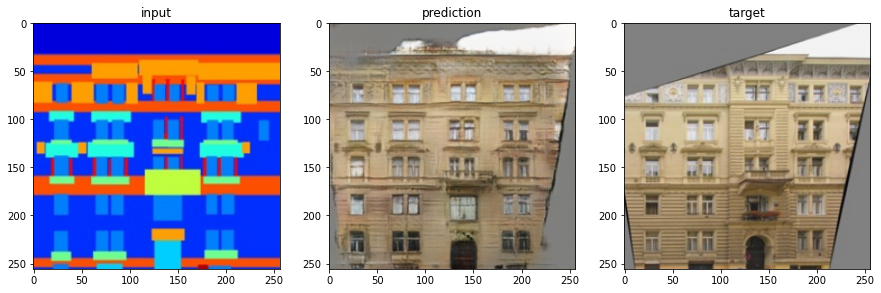

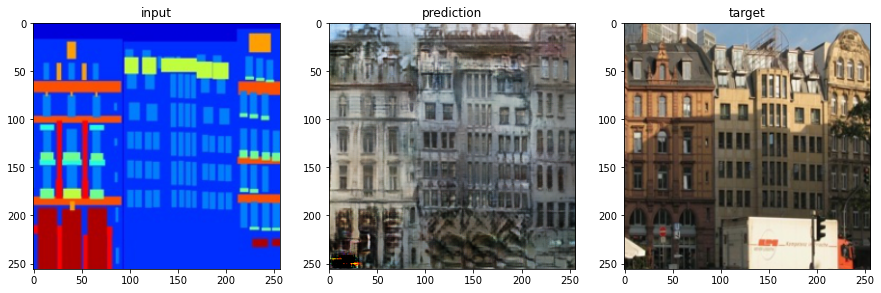

epoch: 960
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])


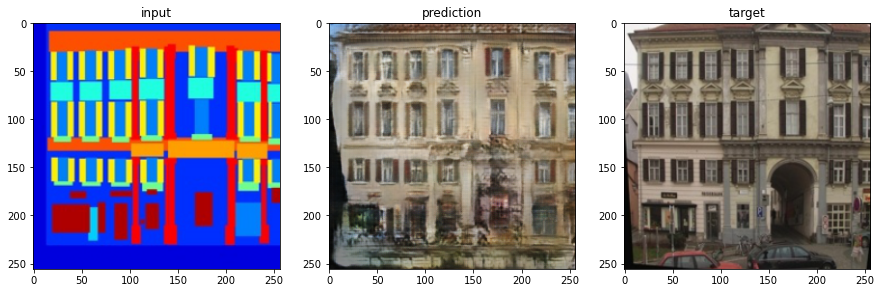

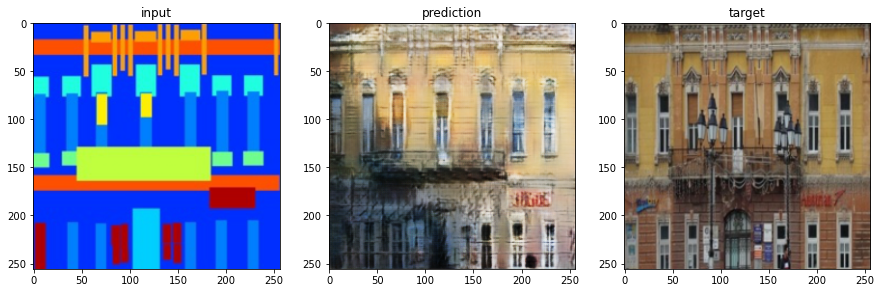

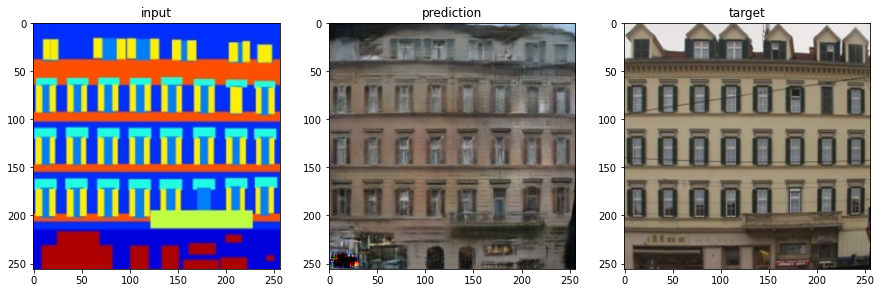

epoch: 1000
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])


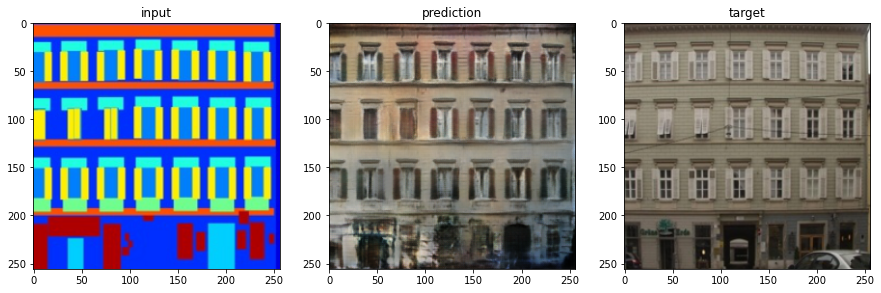

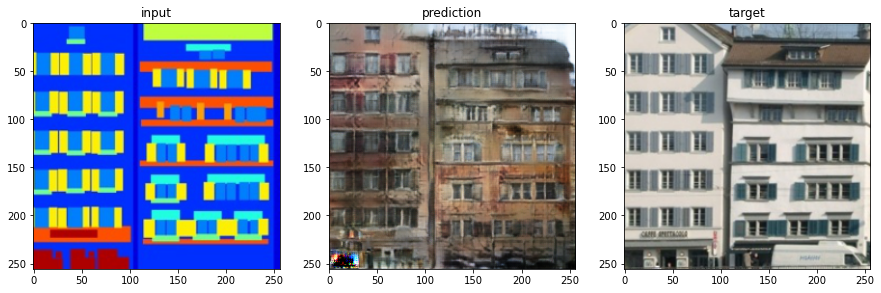

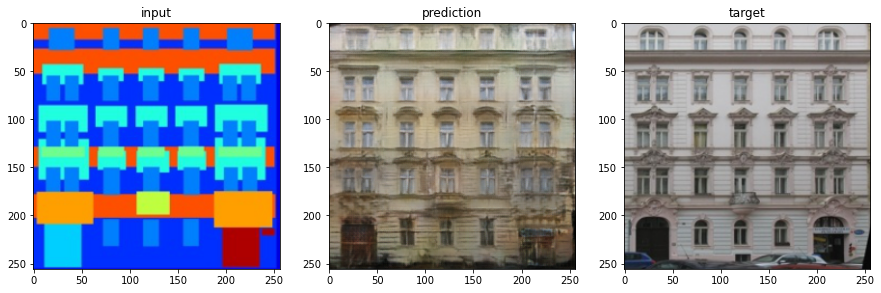

In [21]:
epochs = 200

pbar = tqdm_notebook(total = epochs*(len(train_dataset)//batch_size))
for epoch in range(epochs):
    running_loss_d = 0.0
    running_loss_g = 0.0
    val_loss = 0.0

    ctr=0
    val_ctr=0

    model.train()
    for batch in train_loader:
        A, B = batch
        A = A.to(device)
        B = B.to(device)
        gloss, dloss = model.step(A, B)
        running_loss_g += gloss
        running_loss_d += dloss
        ctr+=1
        pbar.update(1)
    #wandb.log({"Generator loss:": running_loss_g/ctr, "Discriminator loss:": running_loss_d/ctr})
    print('epoch', epoch+1, ':', 'Generator loss:', running_loss_g/ctr, 'Discriminator loss:', running_loss_d/ctr)
    if (epoch+1) % 40 == 0:
        print('epoch:', 800+epoch+1)
        for batch in val_loader:
            test_A, test_B = batch
            prediction(model, test_A, test_B, device)
            break


pbar.close()